In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

In [2]:
### Implementation of Survival Analysis in Python

In [3]:
tut_url = 'https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e'
tut_url = 'https://github.com/anurag-code/Survival-Analysis-Lifelines/blob/master/Survival%20Analysis%20-%20Quick%20Implementation.ipynb'

In [4]:
durations = [5, 6, 6, 2.5, 4, 4]
event_observed = [1, 0, 0, 1, 1, 1]

In [5]:
kmf = KaplanMeierFitter()

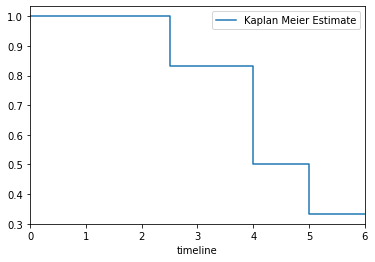

In [6]:
kmf.fit(durations, event_observed, label='Kaplan Meier Estimate')
kmf.plot(ci_show=False)

In [31]:
kmf.survival_function_

,Kaplan Meier Estimate
timeline,
0.0,1.000000
2.5,0.833333
4.0,0.500000
5.0,0.333333
6.0,0.333333


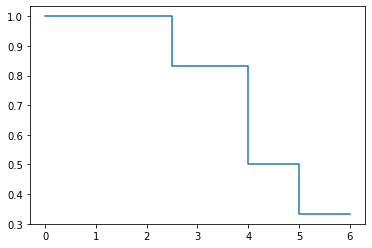

In [30]:
### recreate SA curve in plt
plt.step(kmf.survival_function_.index, kmf.survival_function_.iloc[:, 0].values, where='post')

In [38]:
kmf.confidence_interval_survival_function_

,Kaplan Meier Estimate_upper_0.95,Kaplan Meier Estimate_lower_0.95
0.0,NaN,NaN
2.5,0.974712,0.273123
4.0,0.803709,0.110948
5.0,0.675564,0.046082
6.0,0.675564,0.046082


## Telco Example

In [32]:
kmf1 = KaplanMeierFitter()

In [33]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

print(df.shape)
df.head(2)

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [34]:
## Convert TotalCharges to numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

## Replace yes and No in the Churn column to 1 and 0. 1 for the event and 0 for the censured data.
df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )

In [35]:
df.Churn.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [36]:
T = df.tenure     ## time to event
E = df.Churn      ## event occurred or censored
groups = df.StreamingTV
i1 = (groups == 'No')
i2 = (groups == 'Yes')

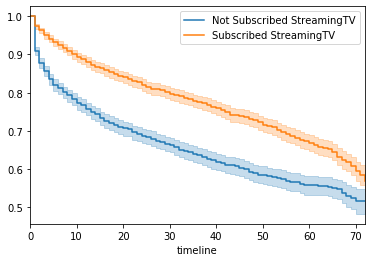

In [37]:
## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Not Subscribed StreamingTV')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Subscribed StreamingTV')
kmf1.plot(ax=a1)

In [16]:
kmf1.event_table[:10]

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0,4,0,4,2707,2707
1,80,69,11,0,2703
2,45,31,14,0,2623
3,57,33,24,0,2578
4,38,24,14,0,2521
5,36,24,12,0,2483
6,30,17,13,0,2447
7,40,23,17,0,2417
8,31,19,12,0,2377


## Cox Proportional Hazard Model

In [19]:
from lifelines import CoxPHFitter

In [20]:
df_r= df[['tenure', 'Churn', 'gender', 'Partner', 'Dependents', 'PhoneService','MonthlyCharges','SeniorCitizen','StreamingTV']]

df_r.head() ## have a look at the data

,tenure,Churn,gender,Partner,Dependents,PhoneService,MonthlyCharges,SeniorCitizen,StreamingTV
0,1,0,Female,Yes,No,No,29.85,0,No
1,34,0,Male,No,No,Yes,56.95,0,No
2,2,1,Male,No,No,Yes,53.85,0,No
3,45,0,Male,No,No,No,42.30,0,No
4,2,1,Female,No,No,Yes,70.70,0,No


In [21]:
## Create dummy variables
df_dummy = pd.get_dummies(df_r, drop_first=True)
df_dummy.head()

,tenure,Churn,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
0,1,0,29.85,0,0,1,0,0,0,0
1,34,0,56.95,0,1,0,0,1,0,0
2,2,1,53.85,0,1,0,0,1,0,0
3,45,0,42.30,0,1,0,0,0,0,0
4,2,1,70.70,0,0,0,0,1,0,0


In [22]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object

In [23]:
cph.fit(df_dummy, 'tenure', event_col='Churn')   ## Fit the data to train the model
cph.print_summary()    ## HAve a look at the significance of the features

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15182.39
         time fit was run = 2019-11-22 13:24:42 UTC

---
                                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
MonthlyCharges                   -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
SeniorCitizen                     0.40       1.49       0.06             0.29             0.50                 1.33                 1.66
gender_Male                      -0.01       0.99       0.05            -0.10             0.08                 0.90                 1.08
Partner_Yes                      -0.81       0.45       0.05            -0.92            -0.70                 0.40        

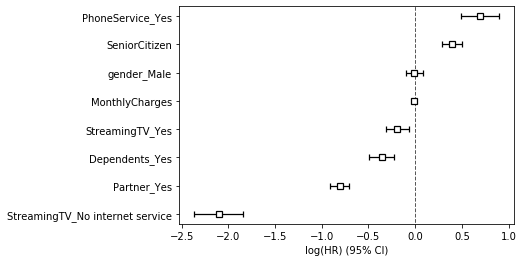

In [24]:
cph.plot()

In [25]:
## We want to see the Survival curve at the customer level. Therefore, we have selected 6 customers (rows 5 till 9).

tr_rows = df_dummy.iloc[5:10, 2:]
tr_rows

,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
5,99.65,0,0,0,0,1,0,1
6,89.10,0,1,0,1,1,0,1
7,29.75,0,0,0,0,0,0,0
8,104.80,0,0,1,0,1,0,1
9,56.15,0,1,0,1,1,0,0


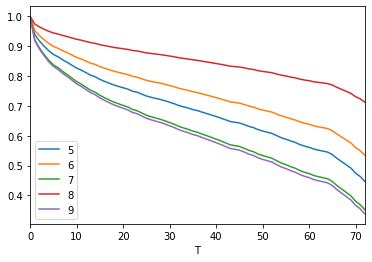

In [26]:
## Lets predict the survival curve for the selected customers. 
## Customers can be identified with the help of the number mentioned against each curve.
cph.predict_survival_function(tr_rows).plot()

## lifelines built-in dataset

In [27]:
from lifelines.datasets import load_waltons

In [28]:
df = load_waltons()

print(df.shape)
df.head()

(163, 3)


,T,E,group
0,6.0,1,miR-137
1,13.0,1,miR-137
2,13.0,1,miR-137
3,13.0,1,miR-137
4,19.0,1,miR-137


In [29]:
df.E.value_counts()

1    156
0      7
Name: E, dtype: int64

In [30]:
df.group.value_counts()

control    129
miR-137     34
Name: group, dtype: int64

In [31]:
T = df['T']
E = df['E']

In [32]:
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter: fitted with 163 total observations, 7 right-censored observations>

In [33]:
kmf.median_survival_time_

56.0

In [34]:
kmf.survival_function_.head(10)

,KM_estimate
timeline,
0.0,1.000000
6.0,0.993865
7.0,0.987730
9.0,0.969210
13.0,0.950690
15.0,0.938344
17.0,0.932170
19.0,0.913650
22.0,0.888957


In [35]:
kmf.cumulative_density_.head(10)

,KM_estimate
timeline,
0.0,0.000000
6.0,0.006135
7.0,0.012270
9.0,0.030790
13.0,0.049310
15.0,0.061656
17.0,0.067830
19.0,0.086350
22.0,0.111043


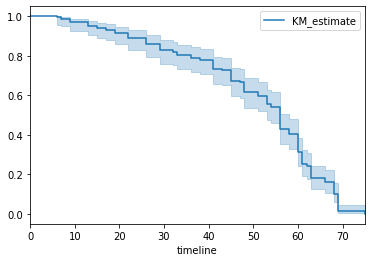

In [36]:
kmf.plot_survival_function() # or just kmf.plot()

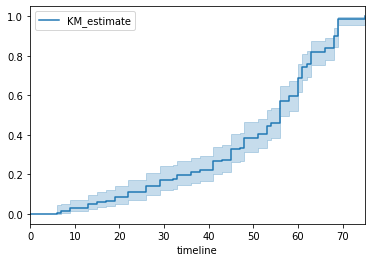

In [37]:
kmf.plot_cumulative_density()

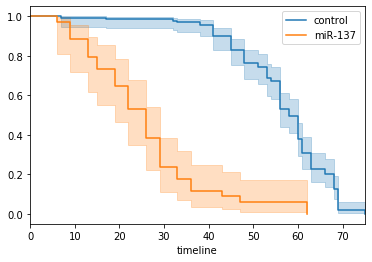

In [38]:
groups = df['group']
ix = (groups == 'miR-137')

kmf.fit(T[~ix], E[~ix], label='control')
ax = kmf.plot()

kmf.fit(T[ix], E[ix], label='miR-137')
ax = kmf.plot(ax=ax)

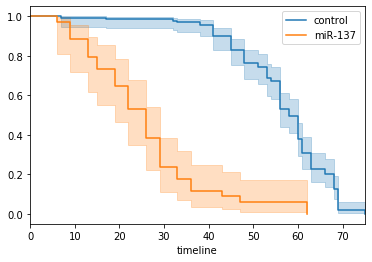

In [39]:
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for name, grouped_df in df.groupby('group'):
    kmf.fit(grouped_df["T"], grouped_df["E"], label=name)
    kmf.plot(ax=ax)

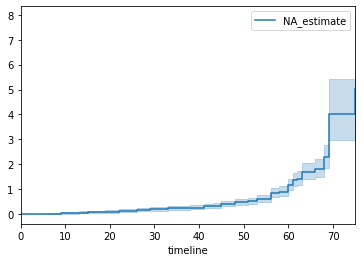

In [40]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()
naf.fit(T, event_observed=E)
naf.plot()